# Sentiment Classification
Prepared by Jan Christian Blaise Cruz

In this notebook we'll see how to use PyTorch to build LSTM-based sentiment classifiers.

# Preliminaries

First, we'll download the necessary files and datasets.

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

We'll import out libraries and set the necessary random seeds.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils

import pandas as pd
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42);
torch.cuda.manual_seed(42);
torch.backends.cudnn.deterministic = True

Let's load the dataset, shuffle it, and separate it into training and validation splits.

In [0]:
df = pd.read_csv('train_40.csv').sample(frac=1, random_state=42)
text, sentiment = list(df['text']), list(df['sentiment'])

tr_sz = int(len(text) * 0.7)

X_train, y_train = text[:tr_sz], sentiment[:tr_sz]
X_val, y_val = text[tr_sz:], sentiment[tr_sz:]

Let's see how much we have in each split.

In [0]:
print("Training Set: {}\nValidation Set: {}".format(len(X_train), len(X_val)))

Training Set: 7000
Validation Set: 3000


# Text Preprocessing

First order of business is to tokenize our dataset. Tokenization refers to splitting a sequence of text into a sequence of **tokens**. There are many different ways to turn words to tokens, but space-splitting is the most common form.

Let's use the ```nltk``` package to tokenize our sentences.

In [0]:
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We'll define a helper function to tokenize a certain sentence ```t```. The ```nltk``` package changes quotes to ``` `` ``` and ```''``` respectively because this is how the PennTreebank tokenizes quotations, so we'll have to change those back.

In [0]:
def tokenize(t):
  return [token.replace('``', '"').replace("''", '"') for token in word_tokenize(t)]

Let's tokenize our sentences.

In [0]:
X_train = [tokenize(t) for t in tqdm(X_train)]
X_val = [tokenize(t) for t in tqdm(X_val)]

100%|██████████| 3000/3000 [00:06<00:00, 472.97it/s]


And check the first item in the training set.

In [0]:
X_train[0][:5]

['I', "'m", 'a', 'huge', 'fan']

Next thing to do is build our vocabulary. We'll define an ```idx2word``` lookup table for quick lookups (and a ```word2idx``` later on for the opposite lookup). We define a set ```vocab_set``` for quick membership checking.

In [0]:
idx2word = {0: '<unk>', 1: '<pad>'}
vocab_set = set(idx2word.values())

# Add the word to the vocabulary if it's not in the vocab set
for text in tqdm(X_train):
  for word in text:
    if word not in vocab_set:
      idx2word[len(vocab_set)] = word
      vocab_set.add(word)
  
# Reverse the idx2word dictionary
word2idx = {idx2word[ix]: ix for ix in range(len(vocab_set))}

100%|██████████| 7000/7000 [00:00<00:00, 21154.92it/s]


Let's check how many tokens we have in the vocabulary.

In [0]:
len(vocab_set)

63885

Next, we'll have the convert the tokens into their vocabulary indices (as networks cannot take raw words/tokens). We'll also have to set a maximum sequence length (msl). If a sentence is too long, we cut it, otherwise we pad it.

We'll write another helper function for this.

In [0]:
def vectorize(text, word2idx, vocab_set, msl):
  v_text = [word2idx[word] if word in vocab_set else word2idx['<unk>'] for word in text]
  
  # Truncate to MSL
  v_text = v_text[:msl]
  
  # If shorter than MSL, pad the sequence
  if len(v_text) < msl:
    v_text = v_text + [word2idx['<pad>'] for _ in range(msl - len(v_text))]
  
  return v_text

Let's set the maximum sequence length to 128 and process the training and validation sets.

In [0]:
msl = 128

X_train =  [vectorize(text, word2idx, vocab_set, msl) for text in tqdm(X_train)]
X_val =  [vectorize(text, word2idx, vocab_set, msl) for text in tqdm(X_val)]

100%|██████████| 3000/3000 [00:00<00:00, 14056.43it/s]


Let's check the first item again.

In [0]:
X_train[0][:5]

[2, 3, 4, 5, 6]

We now convert the lists of lists into a tensor.

In [0]:
X_train = torch.LongTensor(X_train)
X_val = torch.LongTensor(X_val)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

Let's check their shapes.

In [0]:
print("{}\n{}\n{}\n{}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

torch.Size([7000, 128])
torch.Size([7000])
torch.Size([3000, 128])
torch.Size([3000])


And build the minibatches using dataloaders.

In [0]:
bs = 32

train_set = data_utils.TensorDataset(X_train, y_train)
val_set = data_utils.TensorDataset(X_val, y_val)

train_loader = data_utils.DataLoader(train_set, bs)
val_loader = data_utils.DataLoader(val_set, bs)

We can check the number of batches available.

In [0]:
print("Number of training batches: {}".format(len(train_loader)))
print("Number of validation batches: {}".format(len(val_loader)))

Number of training batches: 219
Number of validation batches: 94


Let's inspect the batches.

In [0]:
batches = [b for b in train_loader]

Here's the first batch.

In [0]:
x, y = batches[0]
x.shape, y.shape

(torch.Size([32, 128]), torch.Size([32]))

We can check the information inside the data and the targets.

In [0]:
x, y

(tensor([[   2,    3,    4,  ...,   78,   84,   19],
         [ 164,  165,  166,  ...,  231,  232,  233],
         [ 150,   43,  379,  ...,    1,    1,    1],
         ...,
         [   2,  250,  114,  ...,  579,  433, 2083],
         [  91, 2414,   91,  ...,    7, 2446,   23],
         [  98,  156, 2454,  ...,   23,    1,    1]]),
 tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
         0, 1, 0, 1, 1, 1, 0, 0]))

Likewise, we can check the last batch and see that it has less than 32 items.

In [0]:
x, y = batches[-1]
x.shape, y.shape

(torch.Size([24, 128]), torch.Size([24]))

# Basic Recurrent Neural Networks

Next, we'll build a sentiment classifier. We'll first implement a basic Long Short-Term Memory (LSTM) Network (Hochreiter & Schmidhuber, 1997) for this. 

First things first, we'll look at how embeddings work in PyTorch. We can construct an embedding lookup layer using the ```nn.Embedding``` interface, supplying the size of ouur vocabulary and the dimensions of the emeddings we want.

For this example, we'll use 100-dimensional embeddings. Each token $x$ will be represented by a vector $v \in E^{100}$.

In [0]:
vocab_sz = len(vocab_set)
emb_dim = 100

embeddings = nn.Embedding(vocab_sz, emb_dim)

Since PyTorch is eager by default, we can check how the embeddings look and behave. Let's get the first batch.

Note that ```x``` is a tensor of shape $[bs , msl]$.

In [0]:
x, y = batches[0]

Let's pass it through the embedding layer.

In [0]:
out = embeddings(x)

And check the shape.

In [0]:
out.shape

torch.Size([32, 128, 100])

We've now added a third dimension as each token in each sentence has been expended to a size-100 vector.

We can check the first item in the batch.

In [0]:
out[0].shape, out[0]

(torch.Size([128, 100]),
 tensor([[-0.5208, -0.9320,  0.1852,  ...,  0.7122, -0.0318,  0.1016],
         [ 1.3433,  0.7133,  0.3463,  ...,  0.8244,  1.4862, -1.4091],
         [-0.7602, -0.4075,  0.9624,  ...,  0.0950, -0.7526, -0.6472],
         ...,
         [ 0.1549, -0.2794,  0.8709,  ...,  0.8653,  0.4257, -0.2335],
         [-0.7383, -0.7052,  0.4542,  ..., -1.1416, -1.5392, -1.1881],
         [ 1.0186, -0.1513, -0.9719,  ...,  0.4532,  1.1673,  0.7931]],
        grad_fn=<SelectBackward>))

We can see the shape $[msl, emb\_dim]$ as each token in the 128-length sequence is assigned a 100-dimension vector to represent it. These embeddings will be trained with the network as we go.

We're now ready to pass on the data to an LSTM layer. PyTorch provides an ```nn.LSTM``` interface, passing in the embedding dimensions and our desired number of hidden units for the recurrent layer.

You may type in ```nn.LSTM?``` to check inline documentation for the module.

In [0]:
hidden_dim = 128

rnn = nn.LSTM(emb_dim, hidden_dim)

Next, we'll have to instantiate the initial hidden and cell states, both of which should contain zeros. They're of shape $[1, bs, hidden\_dim]$ each.

The hidden state acts as a "long term memory" tape for the model, while the cell state acts as "short term memory" that the LSTM can use while calculating which information to pass on from the current timestep.

For more information on how LSTMs work, refer to Section 10.10 of Deep Learning (Goodfellow, Bengio & Courville, 2016).

In [0]:
h, c = torch.zeros(1, bs, hidden_dim), torch.zeros(1, bs, hidden_dim)

LSTMs in PyTorch require inputs with the shape $[msl, bs, emb\_dim]$, but our current embedded inputs are $[bs, msl, emb\_dim]$. We'll have to "permute" the inputs to reshape the dimensions. This is easily done using the ```.permute()``` function.

We can then pass in the data and the initial hidden and cell states, then get our outputs, as well as the updated hidden and cell states.

In [0]:
out = out.permute(1, 0, 2)

out, (h, c) = rnn(out, (h, c))

We can check the shapes of these tensors.

In [0]:
out.shape, h.shape, c.shape

(torch.Size([128, 32, 128]),
 torch.Size([1, 32, 128]),
 torch.Size([1, 32, 128]))

These "encoded features" can then be used in any way we like. In this case, we want to pass it on to a softmax layer to compute probabilities (since we're classifying).

We'll instantiate a linear transform layer, passing on the number of hidden units used by the LSTM, as well as the number of output units, which is 2 since we have 2 labels.

In [0]:
output_dim = 2

fc1 = nn.Linear(hidden_dim, output_dim)

Now, which among the output, the hidden, and the cell states are we to pass on?

Well, in this case we're mostly concerned with the hidden state since it contains the encoded information for all the timesteps in the sequence. We'll want to take the *last hidden state* which contains all the information.

We do it, simply by indexing. Then we can pass it on to our linear layer.

In [0]:
out = h[-1, :, :]

out = fc1(out)

We can check the shape of the output and verify that it is of shape $[bs, out\_dim]$.

In [0]:
out.shape

torch.Size([32, 2])

We can then apply softmax to it, or any other activation for that matter.

In [0]:
torch.softmax(out, dim=-1)[:5]

tensor([[0.5328, 0.4672],
        [0.5253, 0.4747],
        [0.5448, 0.4552],
        [0.4985, 0.5015],
        [0.4885, 0.5115]], grad_fn=<SliceBackward>)

Putting it all together into an ```nn.Module```, we get our final model.

We'll also add in a ```nn.Dropout``` layer to regularize our network a bit.

In [0]:
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_sz, emb_dim, hidden_dim, out_dim, dropout=0.5):
    super(LSTMClassifier, self).__init__()
    self.embeddings = nn.Embedding(vocab_sz, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hidden_dim)
    self.fc1 = nn.Linear(hidden_dim, out_dim)
    self.dropout = nn.Dropout(dropout)
    
  def init_hidden(self, bs):
    h, c = torch.zeros(1, bs, self.rnn.hidden_size), torch.zeros(1, bs, self.rnn.hidden_size)
    
    # The following line simply checks if the weights are in the GPU.
    # If they are, put the hidden and cell states in GPU as well.
    if next(model.parameters()).is_cuda:
      h = h.to(device)
      c = c.to(device)
    return h, c
    
  def forward(self, x):
    bs, msl = x.shape
    h, c = self.init_hidden(bs)
    
    out = self.embeddings(x).permute(1, 0, 2)
    out, (h, c) = self.rnn(out, (h, c))
    out = h[-1, :, :]
    out = self.dropout(out)
    
    out = self.fc1(out)
    
    return out

We can instantiate an instance of our model.

In [0]:
model = LSTMClassifier(vocab_sz=len(vocab_set), emb_dim=100, hidden_dim=128, out_dim=2)

And check it's architecture quickly.

In [0]:
model

LSTMClassifier(
  (embeddings): Embedding(63885, 100)
  (rnn): LSTM(100, 128)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
)

Let's test it out by taking a batch.

In [0]:
x, y = batches[0]

And passing it on to the model.

In [0]:
out = model(x)

And we get the expected shapes.

In [0]:
print(out.shape)
print(out[:5])

torch.Size([32, 2])
tensor([[-0.2072,  0.0464],
        [-0.0998,  0.1200],
        [-0.0274,  0.1417],
        [ 0.0304,  0.0217],
        [ 0.0453,  0.2848]], grad_fn=<SliceBackward>)


We can then compute a loss. We'll use cross entropy as our criterion.

In [0]:
criterion = nn.CrossEntropyLoss()

Taking the loss is simple.

In [0]:
loss = criterion(out, y)

And we can see the output.

In [0]:
loss

tensor(0.6813, grad_fn=<NllLossBackward>)

Likewise we can compute for accuracy.

How this function works: ```torch.exp()``` undos the natural log on the softmax, then ```torch.max(dim=1)``` finds the max on the first dimension. This function gives two outputs, the second one is the index of the max values (either 0 and 1) and that's what we want. We compare with our target $y$, take the value, then compute the percentage.

In [0]:
def accuracy(out, y):
  return torch.sum(torch.max(torch.exp(out), dim=1)[1] == y).item() / len(y)

And we get our accuracy.

In [0]:
accuracy(out, y)

0.5625

# Training

We can instantiate our model and optimizers for training. We'll use Adam (Kingma & Ba, 2014) for this.

In [0]:
model = LSTMClassifier(vocab_sz=len(vocab_set), emb_dim=100, hidden_dim=128, out_dim=2, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

We'll train for 10 epochs. We'll also keep track of the losses so we can graph them later.

For this example, we'll also employ some gradient clipping to prevent the gradients from exploding.

In [0]:
epochs = 10
clip = 0.25
train_losses = []
val_losses = []

for e in range(1, epochs + 1):
  train_loss = 0
  train_acc = 0

  model.train()
  for batch in tqdm(train_loader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    out = model(x)
    loss = criterion(out, y)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    train_loss += loss.item()
    train_acc += accuracy(out, y)

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  
  train_losses.append(train_loss)

  val_loss = 0
  val_acc = 0

  model.eval()
  for batch in tqdm(val_loader):
    with torch.no_grad():
      x, y = batch
      x = x.to(device)
      y = y.to(device)

      out = model(x)
      loss = criterion(out, y)

      val_loss += loss.item()
      val_acc += accuracy(out, y)

  val_loss /= len(val_loader)
  val_acc /= len(val_loader)
  
  val_losses.append(val_loss)

  print("\nEpoch {:3} | Train Loss: {:.4f} | Train Acc: {:.4f} | Val Loss: {:.4f} | Val Acc: {:.4f}".format(e, train_loss, train_acc, val_loss, val_acc))

  2%|▏         | 4/219 [00:00<00:05, 36.25it/s]


Epoch   1 | Train Loss: 0.6951 | Train Acc: 0.5073 | Val Loss: 0.6924 | Val Acc: 0.5171


  2%|▏         | 4/219 [00:00<00:06, 35.61it/s]


Epoch   2 | Train Loss: 0.6928 | Train Acc: 0.5223 | Val Loss: 0.6916 | Val Acc: 0.5228


  2%|▏         | 4/219 [00:00<00:05, 36.57it/s]


Epoch   3 | Train Loss: 0.6912 | Train Acc: 0.5300 | Val Loss: 0.6913 | Val Acc: 0.5227


  2%|▏         | 4/219 [00:00<00:05, 37.59it/s]


Epoch   4 | Train Loss: 0.6897 | Train Acc: 0.5369 | Val Loss: 0.6909 | Val Acc: 0.5301


  2%|▏         | 4/219 [00:00<00:05, 36.77it/s]


Epoch   5 | Train Loss: 0.6876 | Train Acc: 0.5446 | Val Loss: 0.6904 | Val Acc: 0.5275


  2%|▏         | 4/219 [00:00<00:05, 36.59it/s]


Epoch   6 | Train Loss: 0.6844 | Train Acc: 0.5609 | Val Loss: 0.6900 | Val Acc: 0.5265


  2%|▏         | 4/219 [00:00<00:05, 36.60it/s]


Epoch   7 | Train Loss: 0.6821 | Train Acc: 0.5713 | Val Loss: 0.6896 | Val Acc: 0.5320


  2%|▏         | 4/219 [00:00<00:05, 36.12it/s]


Epoch   8 | Train Loss: 0.6783 | Train Acc: 0.5806 | Val Loss: 0.6884 | Val Acc: 0.5382


  2%|▏         | 4/219 [00:00<00:06, 35.66it/s]


Epoch   9 | Train Loss: 0.6712 | Train Acc: 0.5946 | Val Loss: 0.6831 | Val Acc: 0.5603


100%|██████████| 94/94 [00:00<00:00, 142.97it/s]


Epoch  10 | Train Loss: 0.6476 | Train Acc: 0.6238 | Val Loss: 0.6394 | Val Acc: 0.6437


We can then plot our loss curves.

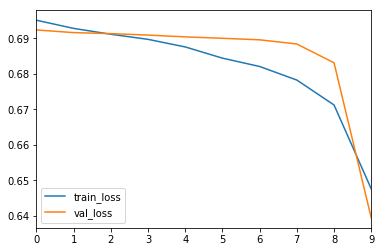

In [0]:
pd.DataFrame(data={'train_loss': train_losses, 'val_loss': val_losses}).plot.line()

# Bidirectional + Stacked LSTMs and Pretrained Embeddings

In this segment, we'll add more capacity to our basic LSTM network by introducing bidirectionality, stacking more LSTMs, and using pretrained embeddings.

Likewise, let's take a batch first.

In [0]:
x, y = batches[0]

Let's build our embedding and LSTM layers. We see some new stuff in here.

You can specify the number of stacked LSTMs you want (default is 1). Bidirectionality is a boolean you can pass on. We can also introduce dropout between each LSTM layer if the number of layers is > 1.

In [0]:
vocab_sz = len(vocab_set)
emb_dim = 100
hidden_dim = 128
out_dim = 2
num_layers = 2
bidirectional = True
recur_dropout = 0.3

embeddings = nn.Embedding(vocab_sz, emb_dim)
rnn = nn.LSTM(emb_dim, hidden_dim, bidirectional=bidirectional, 
              num_layers=num_layers, dropout=recur_dropout)

One of the two things that changes is the shape of the hidden and cell states.

Earlier, we simply have states of shape $[1, bs, hidden\_dim]$.

When stacking LSTM layers, each layer gets its own hidden and cell state tensors. A two-layer stacked LSTM thus has states of shape $[2, bs, hidden\_dim]$.

If the network is bidirectional, each layer gets **two** hidden and cell states, one for the forward pass, and the other for the backward pass. A two-layer bidirectional LSTM thus has states of shape $[4, bs, hidden\_dim]$, and a three layer bidirectional one has $[6, bs, hidden\_dim]$.

In [0]:
direction = 2 if bidirectional else 1

h, c = torch.zeros(direction * num_layers, bs, hidden_dim), torch.zeros(direction * num_layers, bs, hidden_dim)

We check the shapes of our states.

In [0]:
h.shape, c.shape

(torch.Size([4, 32, 128]), torch.Size([4, 32, 128]))

And passing it on remains the same.

In [0]:
out = embeddings(x).permute(1, 0, 2)
out, (h, c) = rnn(out, (h, c))

We can check the shapes of the outputs.

In [0]:
out.shape, h.shape, c.shape

(torch.Size([128, 32, 256]),
 torch.Size([4, 32, 128]),
 torch.Size([4, 32, 128]))

**If the network is bidirectional**, indexing the hidden state changes. We take the last two tensors and concatenate them along the first dimension. This represents the last forward and last backward hidden states, which contains all the encoded information. 



In [0]:
out = torch.cat( (h[-1, :, :], h[-2, :, :]) , dim=1)

This operation results in a tensor of shape $[bs, hidden\_dim * 2]$.

In [0]:
out.shape

torch.Size([32, 256])

So if the network is bidirectional, the next layer should also have twice the number of input dimensions.

In [0]:
fc1 = nn.Linear(hidden_dim * 2, out_dim)

Everything else remains the same.

In [0]:
out = fc1(out)

We can check the sizes of the tensors.

In [0]:
print(out.shape)
print(out[:5])

torch.Size([32, 2])
tensor([[ 0.0130,  0.0247],
        [-0.0189, -0.0212],
        [-0.0286, -0.0009],
        [-0.0332,  0.0102],
        [-0.0160,  0.0012]], grad_fn=<SliceBackward>)


And put everything together into an updated ```LSTMClassifier``` module.

In [0]:
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_sz, emb_dim, hidden_dim, out_dim, bidirectional=False, num_layers=1, dropout=0.5, emb_dropout=0.1, recur_dropout=0.3):
    super(LSTMClassifier, self).__init__()
    self.embeddings = nn.Embedding(vocab_sz, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hidden_dim, bidirectional=bidirectional, num_layers=num_layers, dropout=recur_dropout)
    self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, out_dim)
    self.dropout = nn.Dropout(dropout)
    self.emb_dropout = nn.Dropout(emb_dropout)
    
  def init_hidden(self, bs):
    direction = 2 if self.rnn.bidirectional else 1
    num_layers = self.rnn.num_layers
    h, c = torch.zeros(direction * num_layers, bs, self.rnn.hidden_size), torch.zeros(direction * num_layers, bs, self.rnn.hidden_size)
    
    if next(model.parameters()).is_cuda:
      h = h.to(device)
      c = c.to(device)
    return h, c
    
  def forward(self, x):
    bs, msl = x.shape
    h, c = self.init_hidden(bs)
    
    out = self.embeddings(x).permute(1, 0, 2)
    out = self.emb_dropout(out)
    out, (h, c) = self.rnn(out, (h, c))
    
    if self.rnn.bidirectional:
      out = torch.cat( (h[-1, :, :], h[-2, :, :]) , dim=1)
    else:
      out = h[-1, :, :]
      
    out = self.dropout(out)
    out = self.fc1(out)
    
    return out

Let's instantiate our model and optimizer.

In [0]:
model = LSTMClassifier(vocab_sz=len(vocab_set), emb_dim=100, hidden_dim=128, out_dim=2, dropout=0.5, bidirectional=True, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

But before we train it, let's use pretrained embeddings instead of training our own.

Pretrained embeddings have been standard benchmarks since they provide the network with richer feature representations. For detailed information on how these embeddings are trained, please see Mikolov et al. (2013), Pennington et al. (2014), and Joulin et al. (2017).

For this example, we'll use the 100-dimension GloVe (Pennington et al., 2014) pretrained embeddings from Stanford NLP's repository.

In [0]:
with open('glove.6B.100d.txt', 'r') as f:
  lines = [l.strip() for l in f]
  
# Produce a vocabulary list and a lookup table
emb_vocab = []
word2emb = {}
for l in tqdm(lines):
  l = l.split()
  emb_vocab.append(l[0])
  word2emb[l[0]] = [float(f) for f in l[1:]]

100%|██████████| 400000/400000 [00:15<00:00, 25123.16it/s]


We can check the first item in the embedding vocabulary.

In [0]:
emb_vocab[0], word2emb[emb_vocab[0]][:5]

('the', [-0.038194, -0.24487, 0.72812, -0.39961, 0.083172])

For every word in our own vocabulary, if a corresponding entry appears in the pretrained embeddings, we take those embeddings, otherwise we take a zero-tensor instead.

In [0]:
# Produce a set for O(1) lookups
emb_vocab_set = set(emb_vocab)
emb_dim = 100

# Copy matching embeddings IN ORDER
copied_weights = []
for word in tqdm(word2idx.keys()):
  if word in emb_vocab_set:
    copied_weights.append(word2emb[word])
  else:
    copied_weights.append([0 for _ in range(emb_dim)])
    
# Transform the copied embedding weights into a tensor
copied_weights = torch.stack([torch.FloatTensor(weight) for weight in copied_weights])

100%|██████████| 63885/63885 [00:00<00:00, 187453.99it/s]


We can check the shape of our copied weights and confirm they're of shape $[vocab\_sz, emb\_dim]$.

In [0]:
copied_weights.shape

torch.Size([63885, 100])

We will then copy these weights into the embedding layer of our model, then **freeze** them so the network doesn't update them. They act as feature extractors this way.

In [0]:
model.embeddings.weight.data.copy_(copied_weights);
model.embeddings.weight.requires_grad = False

We then train with the same settings for 10 epochs.

In [0]:
epochs = 50
clip = 0.25
train_losses = []
val_losses = []

for e in range(1, epochs + 1):
  train_loss = 0
  train_acc = 0

  model.train()
  for batch in tqdm(train_loader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    out = model(x)
    loss = criterion(out, y)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    train_loss += loss.item()
    train_acc += accuracy(out, y)

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  
  train_losses.append(train_loss)

  val_loss = 0
  val_acc = 0

  model.eval()
  for batch in tqdm(val_loader):
    with torch.no_grad():
      x, y = batch
      x = x.to(device)
      y = y.to(device)

      out = model(x)
      loss = criterion(out, y)

      val_loss += loss.item()
      val_acc += accuracy(out, y)

  val_loss /= len(val_loader)
  val_acc /= len(val_loader)
  
  val_losses.append(val_loss)

  print("\nEpoch {:3} | Train Loss: {:.4f} | Train Acc: {:.4f} | Val Loss: {:.4f} | Val Acc: {:.4f}".format(e, train_loss, train_acc, val_loss, val_acc))

  1%|          | 2/219 [00:00<00:19, 11.39it/s]


Epoch   1 | Train Loss: 0.6914 | Train Acc: 0.5221 | Val Loss: 0.6853 | Val Acc: 0.6021


  1%|          | 2/219 [00:00<00:18, 11.58it/s]


Epoch   2 | Train Loss: 0.6701 | Train Acc: 0.5973 | Val Loss: 0.6186 | Val Acc: 0.6682


  1%|          | 2/219 [00:00<00:18, 11.89it/s]


Epoch   3 | Train Loss: 0.6263 | Train Acc: 0.6602 | Val Loss: 0.6694 | Val Acc: 0.6411


  1%|          | 2/219 [00:00<00:18, 11.74it/s]


Epoch   4 | Train Loss: 0.6094 | Train Acc: 0.6755 | Val Loss: 0.5722 | Val Acc: 0.7113


  1%|          | 2/219 [00:00<00:19, 11.24it/s]


Epoch   5 | Train Loss: 0.5923 | Train Acc: 0.6958 | Val Loss: 0.5890 | Val Acc: 0.6802


  1%|          | 2/219 [00:00<00:18, 11.77it/s]


Epoch   6 | Train Loss: 0.5797 | Train Acc: 0.7003 | Val Loss: 0.5493 | Val Acc: 0.7281


  1%|          | 2/219 [00:00<00:19, 11.41it/s]


Epoch   7 | Train Loss: 0.5718 | Train Acc: 0.7090 | Val Loss: 0.5550 | Val Acc: 0.7366


  1%|          | 2/219 [00:00<00:18, 11.66it/s]


Epoch   8 | Train Loss: 0.5546 | Train Acc: 0.7202 | Val Loss: 0.6173 | Val Acc: 0.6724


  1%|          | 2/219 [00:00<00:19, 11.39it/s]


Epoch   9 | Train Loss: 0.5475 | Train Acc: 0.7323 | Val Loss: 0.5600 | Val Acc: 0.7092


  1%|          | 2/219 [00:00<00:18, 11.63it/s]


Epoch  10 | Train Loss: 0.5363 | Train Acc: 0.7412 | Val Loss: 0.5462 | Val Acc: 0.7312


  1%|          | 2/219 [00:00<00:18, 11.62it/s]


Epoch  11 | Train Loss: 0.5341 | Train Acc: 0.7414 | Val Loss: 0.5371 | Val Acc: 0.7325


  1%|          | 2/219 [00:00<00:18, 11.51it/s]


Epoch  12 | Train Loss: 0.5259 | Train Acc: 0.7455 | Val Loss: 0.6231 | Val Acc: 0.7040


  1%|          | 2/219 [00:00<00:18, 11.57it/s]


Epoch  13 | Train Loss: 0.5289 | Train Acc: 0.7439 | Val Loss: 0.5232 | Val Acc: 0.7458


  1%|          | 2/219 [00:00<00:18, 11.58it/s]


Epoch  14 | Train Loss: 0.5157 | Train Acc: 0.7517 | Val Loss: 0.5311 | Val Acc: 0.7439


  1%|          | 2/219 [00:00<00:18, 11.60it/s]


Epoch  15 | Train Loss: 0.5075 | Train Acc: 0.7561 | Val Loss: 0.5000 | Val Acc: 0.7696


  1%|          | 2/219 [00:00<00:18, 11.55it/s]


Epoch  16 | Train Loss: 0.5153 | Train Acc: 0.7525 | Val Loss: 0.5260 | Val Acc: 0.7426


  1%|          | 2/219 [00:00<00:18, 11.68it/s]


Epoch  17 | Train Loss: 0.4958 | Train Acc: 0.7678 | Val Loss: 0.5769 | Val Acc: 0.6995


  1%|          | 2/219 [00:00<00:18, 11.57it/s]


Epoch  18 | Train Loss: 0.4970 | Train Acc: 0.7631 | Val Loss: 0.5037 | Val Acc: 0.7516


  1%|          | 2/219 [00:00<00:19, 11.32it/s]


Epoch  19 | Train Loss: 0.5023 | Train Acc: 0.7618 | Val Loss: 0.4904 | Val Acc: 0.7777


  1%|          | 2/219 [00:00<00:18, 11.53it/s]


Epoch  20 | Train Loss: 0.4869 | Train Acc: 0.7721 | Val Loss: 0.4753 | Val Acc: 0.7758


  1%|          | 2/219 [00:00<00:18, 11.51it/s]


Epoch  21 | Train Loss: 0.4837 | Train Acc: 0.7740 | Val Loss: 0.5756 | Val Acc: 0.7047


  1%|          | 2/219 [00:00<00:18, 11.50it/s]


Epoch  22 | Train Loss: 0.4770 | Train Acc: 0.7748 | Val Loss: 0.5053 | Val Acc: 0.7510


  1%|          | 2/219 [00:00<00:19, 11.31it/s]


Epoch  23 | Train Loss: 0.4740 | Train Acc: 0.7769 | Val Loss: 0.4680 | Val Acc: 0.7832


  1%|          | 2/219 [00:00<00:18, 11.94it/s]


Epoch  24 | Train Loss: 0.4659 | Train Acc: 0.7848 | Val Loss: 0.5044 | Val Acc: 0.7540


  1%|          | 2/219 [00:00<00:18, 11.53it/s]


Epoch  25 | Train Loss: 0.4614 | Train Acc: 0.7867 | Val Loss: 0.5288 | Val Acc: 0.7634


  1%|          | 2/219 [00:00<00:18, 11.61it/s]


Epoch  26 | Train Loss: 0.4502 | Train Acc: 0.7911 | Val Loss: 0.4602 | Val Acc: 0.7879


  1%|          | 2/219 [00:00<00:19, 11.41it/s]


Epoch  27 | Train Loss: 0.4480 | Train Acc: 0.7907 | Val Loss: 0.5175 | Val Acc: 0.7500


  1%|          | 2/219 [00:00<00:18, 11.49it/s]


Epoch  28 | Train Loss: 0.4456 | Train Acc: 0.7899 | Val Loss: 0.4618 | Val Acc: 0.7969


  1%|          | 2/219 [00:00<00:17, 12.16it/s]


Epoch  29 | Train Loss: 0.4530 | Train Acc: 0.7927 | Val Loss: 0.4904 | Val Acc: 0.7789


  1%|          | 2/219 [00:00<00:18, 11.48it/s]


Epoch  30 | Train Loss: 0.4419 | Train Acc: 0.7942 | Val Loss: 0.4429 | Val Acc: 0.7932


  1%|          | 2/219 [00:00<00:18, 11.50it/s]


Epoch  31 | Train Loss: 0.4417 | Train Acc: 0.7966 | Val Loss: 0.4392 | Val Acc: 0.7969


  1%|          | 2/219 [00:00<00:18, 11.70it/s]


Epoch  32 | Train Loss: 0.4484 | Train Acc: 0.7944 | Val Loss: 0.4816 | Val Acc: 0.7867


  1%|          | 2/219 [00:00<00:18, 11.52it/s]


Epoch  33 | Train Loss: 0.4367 | Train Acc: 0.7972 | Val Loss: 0.4677 | Val Acc: 0.7883


  1%|          | 2/219 [00:00<00:18, 11.65it/s]


Epoch  34 | Train Loss: 0.4320 | Train Acc: 0.8029 | Val Loss: 0.4687 | Val Acc: 0.7789


  1%|          | 2/219 [00:00<00:18, 11.49it/s]


Epoch  35 | Train Loss: 0.4307 | Train Acc: 0.8087 | Val Loss: 0.5009 | Val Acc: 0.7821


  1%|          | 2/219 [00:00<00:18, 11.47it/s]


Epoch  36 | Train Loss: 0.4343 | Train Acc: 0.8033 | Val Loss: 0.5059 | Val Acc: 0.7788


  1%|          | 2/219 [00:00<00:18, 11.55it/s]


Epoch  37 | Train Loss: 0.4194 | Train Acc: 0.8085 | Val Loss: 0.4534 | Val Acc: 0.8013


  1%|          | 2/219 [00:00<00:18, 11.88it/s]


Epoch  38 | Train Loss: 0.4148 | Train Acc: 0.8125 | Val Loss: 0.5240 | Val Acc: 0.7656


  1%|          | 2/219 [00:00<00:17, 12.30it/s]


Epoch  39 | Train Loss: 0.4185 | Train Acc: 0.8121 | Val Loss: 0.4962 | Val Acc: 0.7752


  1%|          | 2/219 [00:00<00:18, 11.66it/s]


Epoch  40 | Train Loss: 0.4225 | Train Acc: 0.8115 | Val Loss: 0.5649 | Val Acc: 0.7501


  1%|          | 2/219 [00:00<00:18, 11.95it/s]


Epoch  41 | Train Loss: 0.4125 | Train Acc: 0.8150 | Val Loss: 0.4820 | Val Acc: 0.7963


  1%|          | 2/219 [00:00<00:18, 11.59it/s]


Epoch  42 | Train Loss: 0.4024 | Train Acc: 0.8181 | Val Loss: 0.5029 | Val Acc: 0.7815


  1%|          | 2/219 [00:00<00:18, 11.82it/s]


Epoch  43 | Train Loss: 0.3996 | Train Acc: 0.8237 | Val Loss: 0.4934 | Val Acc: 0.7900


  1%|          | 2/219 [00:00<00:18, 11.77it/s]


Epoch  44 | Train Loss: 0.3953 | Train Acc: 0.8279 | Val Loss: 0.5735 | Val Acc: 0.7333


  1%|          | 2/219 [00:00<00:18, 11.82it/s]


Epoch  45 | Train Loss: 0.4008 | Train Acc: 0.8204 | Val Loss: 0.5433 | Val Acc: 0.7516


  1%|          | 2/219 [00:00<00:18, 11.74it/s]


Epoch  46 | Train Loss: 0.3950 | Train Acc: 0.8255 | Val Loss: 0.4648 | Val Acc: 0.7922


  1%|          | 2/219 [00:00<00:18, 11.79it/s]


Epoch  47 | Train Loss: 0.3932 | Train Acc: 0.8309 | Val Loss: 0.4742 | Val Acc: 0.7927


  1%|          | 2/219 [00:00<00:18, 11.89it/s]


Epoch  48 | Train Loss: 0.3784 | Train Acc: 0.8332 | Val Loss: 0.4367 | Val Acc: 0.8029


  1%|          | 2/219 [00:00<00:18, 11.81it/s]


Epoch  49 | Train Loss: 0.3752 | Train Acc: 0.8355 | Val Loss: 0.4906 | Val Acc: 0.7876


100%|██████████| 94/94 [00:01<00:00, 52.23it/s]


Epoch  50 | Train Loss: 0.3908 | Train Acc: 0.8307 | Val Loss: 0.5415 | Val Acc: 0.7537


And plot the losses.

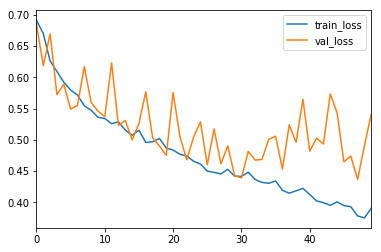

In [0]:
pd.DataFrame(data={'train_loss': train_losses, 'val_loss': val_losses}).plot.line()

# Predictions

We can perform predictions on the model.

Let's put the model back into the CPU and put it in evaluation mode to turn off dropout.

In [0]:
model.cpu()
model.eval()

LSTMClassifier(
  (embeddings): Embedding(63885, 100)
  (rnn): LSTM(100, 128, num_layers=2, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
  (emb_dropout): Dropout(p=0.1)
)

Let's define a prediction function.

In [0]:
def predict(text):
  tokens = tokenize(text)
  vect = vectorize(tokens, word2idx, vocab_set, msl)
  x = torch.LongTensor(vect).unsqueeze(0)

  out = torch.softmax(model(x), dim=1)
  pred = torch.max(out[0], dim=0)[1].item()

  print(pred, out)
  print("Positive") if pred == 0 else print("Negative")

And cast some predictions.

In [0]:
predict("I hated that movie it was very bad")

1 tensor([[0.0412, 0.9588]], grad_fn=<SoftmaxBackward>)
Negative


In [0]:
predict("That was a really good movie!")

0 tensor([[0.9049, 0.0951]], grad_fn=<SoftmaxBackward>)
Positive
